# Session 3 |  Fine-tuning vs. Prompt Engineering

<a href="https://colab.research.google.com/github/dair-ai/maven-pe-for-llms-8/blob/main/demos/session-3/demo-3.2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
%%capture
# update or install the necessary libraries
!pip install --upgrade openai
!pip install --upgrade python-dotenv
!pip install scikit-learn
!pip install pandas
!pip install seaborn
!pip install matplotlib

In [4]:
# load libraries
import openai
import os
import IPython
from dotenv import load_dotenv
import json
import pandas as pd
import json

# load the environment variables
load_dotenv()

# set the OpenAI API key
openai.api_key = os.getenv("OPENAI_API_KEY")

In [5]:
def get_completion( messages, model=None):
    if model == None:
        model = "ft:gpt-3.5-turbo-0613:dair::8kcBpZhV"

    response = openai.chat.completions.create(
        messages=messages,
        model=model
    )
    return response.choices[0].message.content

Quick test of the model:

In [6]:
messages = [
    {
        "role": "system"
,        "content": "Your task is to classify a piece of text into the following emotion labels: [\"anger\", \"fear\", \"joy\", \"love\", \"sadness\", \"surprise\"]."
    },
    {
        "role": "user",
        "content": "I am summer happy!"
    }
]

response = get_completion(messages, model="gpt-3.5-turbo")

Load evaluation:

In [7]:
# Path to your .jsonl file
file_path = '../data/emotion_val_chat.jsonl'

# List to hold the JSON objects
emotion_val_data = []

# Open the file and read each line
with open(file_path, 'r') as file:
    for line in file:
        # Parse the JSON data and append it to the list
        json_obj = json.loads(line)
        emotion_val_data.append(json_obj)

In [8]:
emotion_val_data[0]

{'messages': [{'role': 'system',
   'content': 'Your task is to classify a piece of text into the following emotion labels: ["anger", "fear", "joy", "love", "sadness", "surprise"].'},
  {'role': 'user',
   'content': 'i feel it has only been agitated by the presence of the smoking'},
  {'role': 'assistant', 'content': 'fear'}]}

Get predictions for zero-shot prompt

In [9]:
zeroshot_system_prompt = """Your task is to classify a piece of text into the following emotion labels: [\"anger\", \"fear\", \"joy\", \"love\", \"sadness\", \"surprise\"].

Just output the label as a lowercase string.
"""

In [10]:
gpt35_responses = []

for i in range(len(emotion_val_data)):
    messages = [
        {
            "role": "system",
            "content": zeroshot_system_prompt
        },
        {
            "role": "user",
            "content": emotion_val_data[i]["messages"][1]["content"]
        }
    ]
    gpt35_responses.append(get_completion(messages, model="gpt-3.5-turbo"))

len(gpt35_responses)

120

Get predictions for fine-tuned model:

In [11]:
finetuned_gpt35_responses = []

for i in range(len(emotion_val_data)):
    messages = [
        {
            "role": "system",
            "content": "Your task is to classify a piece of text into the following emotion labels: [\"anger\", \"fear\", \"joy\", \"love\", \"sadness\", \"surprise\"]."
        },
        {
            "role": "user",
            "content": emotion_val_data[i]["messages"][1]["content"]
        }
    ]
    finetuned_gpt35_responses.append(get_completion(messages))

len(finetuned_gpt35_responses)

120

In [12]:
 #store the assistant content from the lists of objects


ground_truth = []

for i in range(len(emotion_val_data)):
    ground_truth.append(emotion_val_data[i]["messages"][2]["content"])


In [13]:
finetuned_gpt35_responses[0:5], ground_truth[0:5], gpt35_responses[0:5]

(['anger', 'sadness', 'surprise', 'love', 'love'],
 ['fear', 'sadness', 'fear', 'love', 'love'],
 ['anger', 'sadness', 'sadness', 'love', 'love'])

Convert the labels for analysis:

In [14]:
df_results = pd.DataFrame(list(zip(finetuned_gpt35_responses, ground_truth, gpt35_responses)), columns =['finetuned_gpt35_responses', 'ground_truth', 'gpt35_responses'])

In [15]:
df_results

,finetuned_gpt35_responses,ground_truth,gpt35_responses
0,anger,fear,anger
1,sadness,sadness,sadness
2,surprise,fear,sadness
3,love,love,love
4,love,love,love
...,...,...,...
115,fear,fear,joy
116,anger,fear,joy
117,fear,fear,fear
118,fear,fear,sadness


In [16]:
completion_map = {
    "anger": 0,
    "fear": 1,
    "joy": 2,
    "love": 3,
    "sadness": 4,
    "surprise": 5
}

completion_map_string = {
    0: "anger",
    1: "fear",
    2: "joy",
    3: "love",
    4: "sadness",
    5: "surprise"
}

df_results["finetuned_gpt35_responses"] = df_results["finetuned_gpt35_responses"].map(completion_map)
df_results["ground_truth"] = df_results["ground_truth"].map(completion_map)
df_results["gpt35_responses"] = df_results["gpt35_responses"].map(completion_map)

Plot fine-tuning results:

([<matplotlib.axis.YTick at 0x7fb80a5533a0>,
 [Text(0, 0, 'anger'),
  Text(0, 1, 'fear'),
  Text(0, 2, 'joy'),
  Text(0, 3, 'love'),
  Text(0, 4, 'sadness'),
  Text(0, 5, 'surprise')])

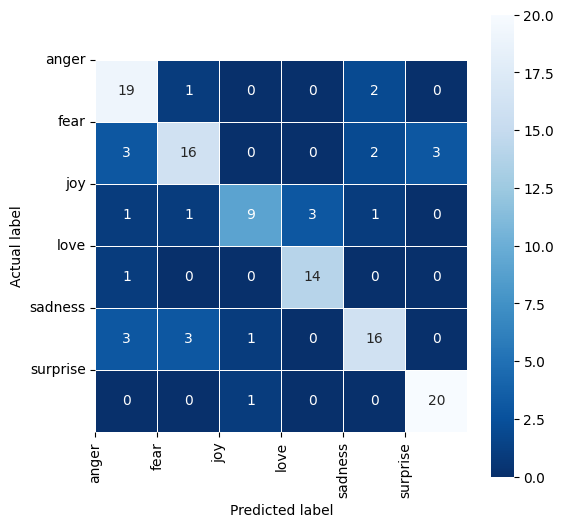

In [17]:
# plot confustion matrix
from sklearn.metrics import confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

confusion_matrix = confusion_matrix(df_results["ground_truth"], df_results["finetuned_gpt35_responses"])

# plot confusion matrix
plt.figure(figsize=(6, 6))
sns.heatmap(confusion_matrix, annot=True, fmt=".0f", linewidths=0.5, square=True, cmap="Blues_r")

# add emotion labels to confusion matrix
plt.ylabel("Actual label")
plt.xlabel("Predicted label")

# annotate the confusion matrix with completion labels
tick_marks = [i for i in range(len(completion_map_string))]
plt.xticks(tick_marks, list(completion_map_string.values()), rotation="vertical")
plt.yticks(tick_marks, list(completion_map_string.values()), rotation="horizontal")

Plotting GPT-3.5 Zero-shot results:

([<matplotlib.axis.YTick at 0x7fb828b4fe20>,
 [Text(0, 0, 'anger'),
  Text(0, 1, 'fear'),
  Text(0, 2, 'joy'),
  Text(0, 3, 'love'),
  Text(0, 4, 'sadness'),
  Text(0, 5, 'surprise')])

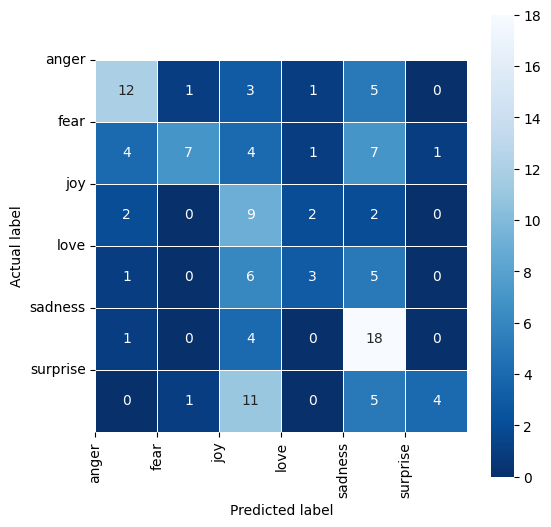

In [18]:
# plot confustion matrix
from sklearn.metrics import confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

confusion_matrix = confusion_matrix(df_results["ground_truth"], df_results["gpt35_responses"])

# plot confusion matrix
plt.figure(figsize=(6, 6))
sns.heatmap(confusion_matrix, annot=True, fmt=".0f", linewidths=0.5, square=True, cmap="Blues_r")

# add emotion labels to confusion matrix
plt.ylabel("Actual label")
plt.xlabel("Predicted label")

# annotate the confusion matrix with completion labels
tick_marks = [i for i in range(len(completion_map_string))]
plt.xticks(tick_marks, list(completion_map_string.values()), rotation="vertical")
plt.yticks(tick_marks, list(completion_map_string.values()), rotation="horizontal")


Plot bar chart to compare fine-grained results:

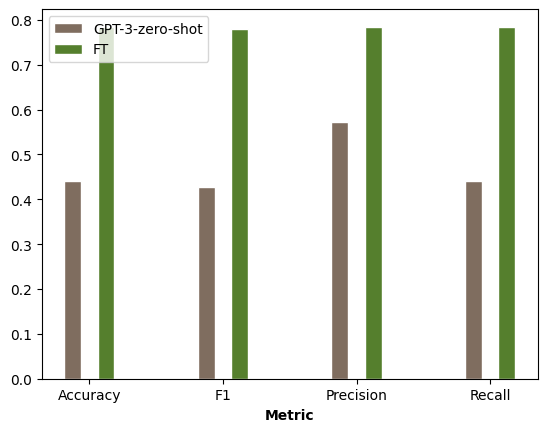

In [21]:
# use scikitlearn to calculate the accuracy score and other metrics like F1
from sklearn.metrics import accuracy_score, f1_score, precision_score, recall_score

gpt_3_acc = accuracy_score(df_results["ground_truth"], df_results["gpt35_responses"])

gpt_3_f1 = f1_score(df_results["ground_truth"], df_results["gpt35_responses"], average="weighted")

gpt_3_precision = precision_score(df_results["ground_truth"], df_results["gpt35_responses"], average="weighted")

gpt_3_recall = recall_score(df_results["ground_truth"], df_results["gpt35_responses"], average="weighted")

finetuned_acc = accuracy_score(df_results["ground_truth"], df_results["finetuned_gpt35_responses"])

finetuned_f1 = f1_score(df_results["ground_truth"], df_results["finetuned_gpt35_responses"], average="weighted")

finetuned_precision = precision_score(df_results["ground_truth"], df_results["finetuned_gpt35_responses"], average="weighted")

finetuned_recall = recall_score(df_results["ground_truth"], df_results["finetuned_gpt35_responses"], average="weighted")


# plot the accuracy, F1, precision, and recall scores in a bar chart
import matplotlib.pyplot as plt

# set width of bar
barWidth = 0.50

# set height of bar
bars1 = [gpt_3_acc, gpt_3_f1, gpt_3_precision, gpt_3_recall]

bars2 = [finetuned_acc, finetuned_f1, finetuned_precision, finetuned_recall]

# Set position of bar on X axis
r1 = [1, 5, 9, 13]
r2 = [2, 6, 10, 14]

# Make the plot
plt.bar(r1, bars1, color="#7f6d5f", width=barWidth, edgecolor="white", label="GPT-3-zero-shot")
plt.bar(r2, bars2, color="#557f2d", width=barWidth, edgecolor="white", label="FT")

# Add xticks on the middle of the group bars, make sure to correct the xticks
plt.xlabel("Metric", fontweight="bold")

# use r1 and r2 positions to set the xticks
plt.xticks([r1[r] + barWidth for r in range(len(bars1))], ["Accuracy", "F1", "Precision", "Recall"])


# Create legend & Show graphic
plt.legend()
plt.show()


Exercise: Add more experiments like few-shot prompting and CoT prompting to see if the performance gap can be reduced. 